### Game of Tic-Tac-Toe
***Taha Adeel Mohammed - CS20BTECH1105***

Implements a Tic-Tac-Toe agent using Q-learning.

In [19]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from abc import ABC, abstractmethod
from typing import List, Tuple, Dict, TypeVar
from tqdm import tqdm
from collections import defaultdict

np.random.seed(0)

#### (a) Tic-Tac-Toe Environment

In [20]:

Agent = TypeVar('Agent') # Forward declaring the Agent class
class TicTacToe:
    def __init__(self, player: Agent, opponent: Agent, render_mode='ascii'):
        '''Creates an empty board and initializes the agents'''
        # Initialize the empty board
        self.board = np.array([['.', '.', '.'], ['.', '.', '.'], ['.', '.', '.']])
        self.num_moves = 0
        self.winner = None
        self.render_mode = render_mode
        
        # Initialize the agents
        self.player = player
        self.player.marker = 'X'
        self.player.env = self
        
        self.opponent = opponent
        self.opponent.marker = 'O'
        self.opponent.env = self
        
        # Randomly choose the starting player
        self.starting_player = np.random.choice([self.player, self.opponent])
        
    def act(self, cell, marker, verbose: bool = False):
        '''Checks if the move is valid and updates the board'''
        if not self.is_valid_move(cell): raise ValueError('Invalid move')
        if self.winner is not None: raise ValueError('Game already over')
        
        if(self.is_winning_move(cell, marker)):
            self.winner = marker
            
        self.board[cell] = marker
        self.num_moves += 1
        
        if(self.num_moves == 9 and self.winner is None): self.winner = 'draw'
        if(verbose): self.print()
    
    def print(self):
        '''Prints the current board position'''
        if(self.render_mode == 'ascii'):
            print('-------------')
            for i in range(3):
                print('|', end=' ')
                for j in range(3):
                    print(self.board[i, j], '|', end=' ')
                print('\n-------------')
    
    def reward(self, marker) -> int:
        '''Returns the reward for the current board position'''
        if self.winner is None: return 0
        elif self.winner == marker: return 100 # Win
        elif self.winner == self.get_opponent_marker(marker): return -100 # Loss
        else: return -5 # Draw
    
    def simulate(self, train: bool = False, verbose: bool = False):
        '''Simulates a game between the agents, training the agents'''
        if self.num_moves == 0 and self.starting_player == self.opponent:
            self.act(self.opponent.get_action(), self.opponent.marker, verbose)
        
        # Play the game until it is over
        while self.winner is None:
            # Do agent move
            self.act(self.player.get_action(), self.player.marker, verbose)
            if train: self.opponent.train() # Does nothing here since opponent is not an AI
            
            if self.winner is None: # Do opponent move
                self.act(self.opponent.get_action(), self.opponent.marker, verbose)
            if train: self.player.train() # Performs the Q-learning update based on current env state
    
    def reset(self):
        '''Resets the board'''
        self.board = np.array([['.', '.', '.'], ['.', '.', '.'], ['.', '.', '.']])
        self.num_moves = 0
        self.winner = None
        self.starting_player = np.random.choice([self.player, self.opponent])
        
    def is_valid_move(self, cell):
        '''Checks if the move is valid'''
        return self.board[cell] == '.'
    
    def get_empty_cells(self):
        '''Returns a list of empty cells'''
        return [(i, j) for i, j in np.argwhere(self.board == '.')]
   
    def get_state(self):
        '''Returns the current board position'''
        return ''.join(self.board.ravel())
    
    def is_winning_move(self, cell, marker):
        '''Checks if the move is a winning move, without doing the move'''
        if not self.is_valid_move(cell): return False
        if np.count_nonzero(self.board[cell[0], :] == marker) == 2: return True
        if np.count_nonzero(self.board[:, cell[1]] == marker) == 2: return True
        if cell[0] == cell[1] and np.count_nonzero(np.diag(self.board) == marker) == 2: return True
        if cell[0] + cell[1] == 2 and np.count_nonzero(np.diag(np.fliplr(self.board)) == marker) == 2: return True
        return False
    
    def get_opponent_marker(self, marker):
        '''Returns the opponent marker'''
        return 'O' if marker == 'X' else 'X'

#### (b) Agents

In [21]:
class Agent(ABC):
	'''Base class for all agents'''
	
	def __init__(self):
		'''Initializes the agent'''
		self.marker: str | None = None
		self.env: TicTacToe | None = None
		self.action: Tuple[int, int] | None = None
		self.old_state: str | None = None
  
	@abstractmethod
	def get_action(self) -> Tuple[int, int]:
		'''Returns the action to be taken by the agent'''
		return NotImplementedError
	
	def train(self) -> None:
		'''Updates the agent's parameters'''
		pass

In [22]:
class RandomAgent(Agent):
	'''Agent that plays randomly'''
	
	def get_action(self) -> Tuple[int, int]:
		'''Randomly chooses an action from the list of possible actions'''
		self.old_state = self.env.get_state()
		actions = self.env.get_empty_cells()
		self.action = actions[np.random.randint(len(actions))]
		return self.action

In [23]:
class SafeAgent(Agent):
	'''Agent that heuristically trys winning or preventing opponent from winning. If not possible, plays randomly'''
 
	def get_action(self) -> Tuple[int, int]:
		'''Returns the action to be taken by the agent'''
		self.old_state = self.env.get_state()
		empty_cells = self.env.get_empty_cells()
		# If the agent can win in the next move, return the action
		for cell in empty_cells:
			if self.env.is_winning_move(cell, self.marker):
				self.action = cell
				return self.action

		# If the opponent can win in the next move, return the action
		for cell in empty_cells:
			if self.env.is_winning_move(cell, self.env.get_opponent_marker(self.marker)):
				self.action = cell
				return self.action

		# Else return a random action
		self.action = empty_cells[np.random.randint(len(empty_cells))]
		return self.action

#### (c) Q-Learning Agent

In [24]:
class QLearningAgent(Agent):
	'''Agent that uses Q-learning to learn the optimal policy'''
	def __init__(self, alpha: float = 0.01, gamma: float = 0.95, epsilon: float = 0.2) -> None:
		'''Initializes the agent, Q-table and hyperparameters'''
		super().__init__()
		self.Q_table = defaultdict(lambda: 0) # Creates a 0-initialized dictionary
		self.alpha = alpha
		self.learning_rate = alpha
		self.gamma = gamma
		self.epsilon = epsilon
		self.test_flag = False
  
	def greedy_action(self) -> Tuple[int, int]:
		'''Returns the action with the maximum Q-value for current env state'''
		actions = self.env.get_empty_cells()
		state = self.env.get_state()
		return max(actions, key=lambda action: self.Q_table[(state, action)])

	def get_action(self) -> Tuple[int, int]:
		'''Returns the action to be taken by the agent'''
		self.old_state = self.env.get_state()
		if np.random.rand() < self.epsilon and not self.test_flag: # With probability epsilon, choose a random action
			actions = self.env.get_empty_cells()
			self.action = actions[np.random.randint(len(actions))]
		else: # Else choose the greedy action
			self.action = self.greedy_action()
		return self.action


	def train(self) -> None:
		'''Updates the agent's parameters'''
		reward = self.env.reward(self.marker)
		state = self.env.get_state()
		self.Q_table[(self.old_state, self.action)] += \
  			self.learning_rate * (reward + self.gamma * max((self.Q_table[(state, action)] for action in self.env.get_empty_cells()), default=0) - self.Q_table[(self.old_state, self.action)])
	
	def test(self, num_games: int = 100, opponent: Agent = RandomAgent()):
		num_wins = 0
		num_draws = 0
		num_losses = 0
		test_env = TicTacToe(self, opponent)
		self.test_flag = True # Set the test flag to True to disable exploration
		for _ in range(num_games):
			test_env.simulate(train=True)
			if test_env.winner == self.marker: num_wins += 1
			elif test_env.winner == 'draw': num_draws += 1
			else: num_losses += 1
			test_env.reset()
   
		self.test_flag = False # Reset the test flag
		return num_wins, num_draws, num_losses


### Training

#### (1) Training against a random agent

  2%|▏         | 201/10000 [00:00<00:08, 1199.39it/s]

100%|██████████| 10000/10000 [00:03<00:00, 2536.07it/s]


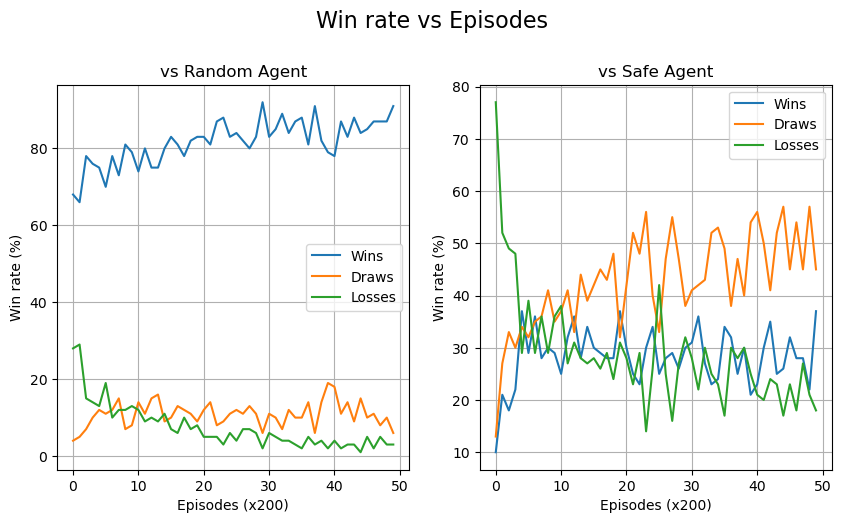

Final number of wins, draws and losses respectively vs RandomAgent:  (871, 94, 35)
Final number of wins, draws and losses respectively vs SafeAgent:  (287, 483, 230)


In [25]:
QAgent1 = QLearningAgent(alpha=0.2, gamma=0.95, epsilon=0.2)
randOp = RandomAgent()

env1 = TicTacToe(QAgent1, randOp)

# Train the agent
num_episodes = 10000
win_rate_rand = []
win_rate_safe = []
for episode in tqdm(range(num_episodes)):
	QAgent1.learning_rate = QAgent1.alpha / (1+episode)
	env1.simulate(train=True)
	if episode % 200 == 0:
		win_rate_rand.append(QAgent1.test(opponent=RandomAgent(), num_games=100))
		win_rate_safe.append(QAgent1.test(opponent=SafeAgent(), num_games=100))
  
# Display the win rate
plt.figure(figsize=(10, 5))
plt.suptitle('Win rate vs Episodes', fontsize=16, y=1.03)

# Vs RandomAgent
plt.subplot(1, 2, 1)
lineObjects=plt.plot(win_rate_rand)
plt.legend(iter(lineObjects), ('Wins', 'Draws', 'Losses'))
plt.ylabel('Win rate (%)')
plt.xlabel('Episodes (x200)')
plt.title('vs Random Agent')
plt.grid()

# Vs SafeAgent
plt.subplot(1, 2, 2)
lineObjects=plt.plot(win_rate_safe)
plt.legend(iter(lineObjects), ('Wins', 'Draws', 'Losses'))
plt.ylabel('Win rate (%)')
plt.xlabel('Episodes (x200)')
plt.title('vs Safe Agent')
plt.grid()

plt.show()

# Final win rate
print('Final number of wins, draws and losses respectively vs RandomAgent: ', QAgent1.test(opponent=RandomAgent(), num_games=1000))
print('Final number of wins, draws and losses respectively vs SafeAgent: ', QAgent1.test(opponent=SafeAgent(), num_games=1000))

#### (2) Training against a self agent

100%|██████████| 10000/10000 [00:03<00:00, 2541.19it/s]


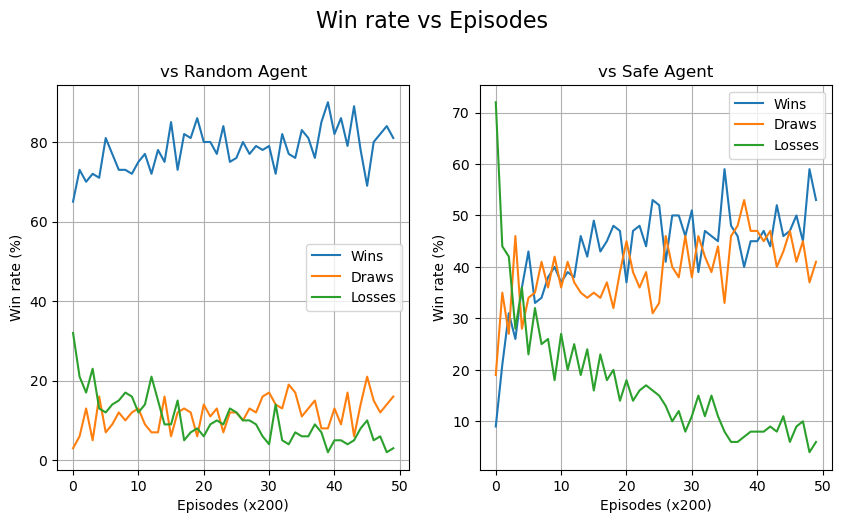

Final number of wins, draws and losses respectively vs RandomAgent:  (824, 145, 31)
Final number of wins, draws and losses respectively vs SafeAgent:  (567, 346, 87)


In [26]:
QAgent2 = QLearningAgent(alpha=0.2, gamma=1, epsilon=1)
safeOp = SafeAgent()

env2 = TicTacToe(QAgent2, safeOp)

# Train the agent
num_episodes = 10000
win_rate_rand = []
win_rate_safe = []
for episode in tqdm(range(num_episodes)):
	# QAgent2.learning_rate = QAgent2.alpha / (1+episode)
	env2.simulate(train=True)
	if episode % 200 == 0:
		win_rate_rand.append(QAgent2.test(opponent=RandomAgent(), num_games=100))
		win_rate_safe.append(QAgent2.test(opponent=SafeAgent(), num_games=100))

# Display the win rate
plt.figure(figsize=(10, 5))
plt.suptitle('Win rate vs Episodes', fontsize=16, y=1.03)

# Vs RandomAgent
plt.subplot(1, 2, 1)
lineObjects=plt.plot(win_rate_rand)
plt.legend(iter(lineObjects), ('Wins', 'Draws', 'Losses'))
plt.ylabel('Win rate (%)')
plt.xlabel('Episodes (x200)')
plt.title('vs Random Agent')
plt.grid()

# Vs SafeAgent
plt.subplot(1, 2, 2)
lineObjects=plt.plot(win_rate_safe)
plt.legend(iter(lineObjects), ('Wins', 'Draws', 'Losses'))
plt.ylabel('Win rate (%)')
plt.xlabel('Episodes (x200)')
plt.title('vs Safe Agent')
plt.grid()

plt.show()

# Final win rate
print('Final number of wins, draws and losses respectively vs RandomAgent: ', QAgent2.test(opponent=RandomAgent(), num_games=1000))
print('Final number of wins, draws and losses respectively vs SafeAgent: ', QAgent2.test(opponent=SafeAgent(), num_games=1000))

#### (3) Training against both random and self agent

100%|██████████| 10000/10000 [00:03<00:00, 2517.57it/s]


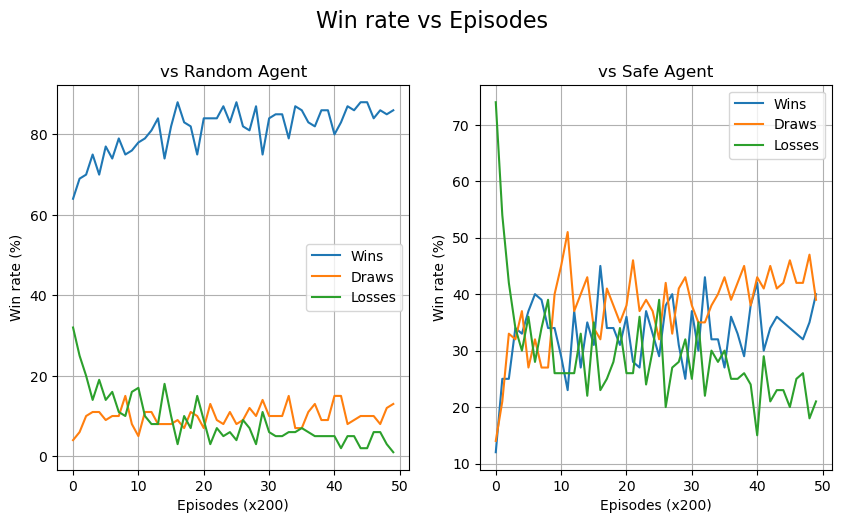

Final number of wins, draws and losses respectively vs RandomAgent:  (848, 105, 47)
Final number of wins, draws and losses respectively vs SafeAgent:  (344, 416, 240)


In [27]:
QAgent3 = QLearningAgent(alpha=0.2, gamma=0.95, epsilon=0.2)
randOp = RandomAgent()
safeOp = SafeAgent()

env3 = TicTacToe(QAgent3, safeOp)
randOp.env = env3
randOp.marker = 'O'

# Train the agent
num_episodes = 10000
win_rate_rand = []
win_rate_safe = []
for episode in tqdm(range(num_episodes)):
	QAgent3.learning_rate = QAgent3.alpha / (1+episode)
	env3.opponent = np.random.choice([randOp, safeOp])
	env3.simulate(train=True)
	if episode % 200 == 0:
		win_rate_rand.append(QAgent3.test(opponent=RandomAgent(), num_games=100))
		win_rate_safe.append(QAgent3.test(opponent=SafeAgent(), num_games=100))
  
# Display the win rate
plt.figure(figsize=(10, 5))
plt.suptitle('Win rate vs Episodes', fontsize=16, y=1.03)

# Vs RandomAgent
plt.subplot(1, 2, 1)
lineObjects=plt.plot(win_rate_rand)
plt.legend(iter(lineObjects), ('Wins', 'Draws', 'Losses'))
plt.ylabel('Win rate (%)')
plt.xlabel('Episodes (x200)')
plt.title('vs Random Agent')
plt.grid()

# Vs SafeAgent
plt.subplot(1, 2, 2)
lineObjects=plt.plot(win_rate_safe)
plt.legend(iter(lineObjects), ('Wins', 'Draws', 'Losses'))
plt.ylabel('Win rate (%)')
plt.xlabel('Episodes (x200)')
plt.title('vs Safe Agent')
plt.grid()

plt.show()


# Final win rate
print('Final number of wins, draws and losses respectively vs RandomAgent: ', QAgent3.test(opponent=RandomAgent(), num_games=1000))
print('Final number of wins, draws and losses respectively vs SafeAgent: ', QAgent3.test(opponent=SafeAgent(), num_games=1000))

#### (4) Which agent is best?

The agent trained against both random and self agent is the best agent considering its overall performance. While the specialized agents perform slightly better against their respective opponents, they perform poorly against the other agent. The agent trained against both random and self agent has better adaptability and performs well against both the agents.

#### (5) Q-Learning Improvements

The Q-learning agent developed, while showing good results, is not unbeatable against any possible opponent. The agent is trained against a random agent and a safe agent that looks only one move ahead. The agent is not trained against an optimal agent, which either draws or wins the game. 

The training process can be improved by training our agent against an optimal agent, or by training it against itself, and hence continuously improving its performance. Also, the final results depend on the number of episodes, learning rate, reward function, etc, on which hyperparameter tuning can be done to improve the performance of the agent.